In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('.'), '..')))
# Two levels up
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('.'), '..', '..')))

In [2]:
%reload_ext autoreload
%autoreload 2

## Import packages

In [3]:
from ga4_api.ga4_api import Ga4Client
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

## Setting parameters

In [4]:
pd.set_option('display.max_rows', 20)

In [5]:
# Parameters
property_id = '394327334'

## Define common functions

In [6]:
def preprocess_import_data(df):
    # Use pandas to convert types to inferred types
    # If column type is numeric, convert to numeric
    for col in df.select_dtypes(include=['object']).columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except ValueError:
            pass
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    return df

def plot_metric_by_date(data, metric):
    plt.figure(figsize=(18, 6))
    sns.lineplot(data=data, x='date', y=metric)
    plt.axvspan(pd.to_datetime('2025-07-05'), pd.to_datetime('2025-09-13'), color='green', alpha=0.1)
    plt.title(f'{metric} Over Time', fontsize='xx-large')
    plt.xlabel('Date', fontsize='large')
    plt.ylabel(metric, fontsize='large')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()


## Initializing Ga4 Client

In [7]:
client = Ga4Client()

## KPIs by Month

In [140]:
months_data = {}

for i, month in enumerate(["January", "February", "March", "April", "May", "June", "July", "August"]):
    if month == "February":
        end_day = 28
    elif month in ["April", "June", "September", "November"]:
        end_day = 30
    else:
        end_day = 31
    # month name
    months_data[month] = client.run_query(
        property_id=property_id,
        start_date=f'2025-{i+1:02d}-01',
        end_date=f'2025-{i+1:02d}-{end_day}',
        metrics=['activeUsers', 'newUsers', 'engagedSessions', 'averageSessionDuration', 'screenPageViews'],
    )

In [141]:
# Build dataframe with all months
import pandas as pd
df = pd.DataFrame()
for month, data in months_data.items():
    temp_df = pd.DataFrame(data)
    temp_df['month'] = month
    df = pd.concat([df, temp_df], ignore_index=True)

df.set_index('month', inplace=True)

# Convert all columns to numeric
df = df.apply(pd.to_numeric)

# Compute difference between months (starting from last row upwards)
df["activeUsers_diff"] = df["activeUsers"].diff().fillna(0)

In [142]:
df

,activeUsers,newUsers,engagedSessions,averageSessionDuration,screenPageViews,activeUsers_diff
month,,,,,,
January,39051,37821,28892,129.503417,66807,0.0
February,29698,28615,21490,145.219544,53584,-9353.0
March,38309,36966,27873,140.568150,72134,8611.0
April,38349,37192,28702,137.903025,69926,40.0
May,36873,35704,26720,133.140834,65108,-1476.0
June,41916,40563,29569,132.645325,75243,5043.0
July,59529,58114,41741,126.605653,100915,17613.0
August,72108,70444,48679,114.083594,114573,12579.0


In [143]:
avg_jan_to_jun = df.loc["January":"June", "activeUsers"].mean()

avg_jan_to_jun
avg_jul_to_aug = df.loc["July":"August", "activeUsers"].mean()

# Difference % between the two averages
diff_avg = (avg_jul_to_aug - avg_jan_to_jun) / avg_jan_to_jun * 100

diff_avg


np.float64(76.14542632339561)

In [144]:
avg_jul_to_aug

np.float64(65818.5)

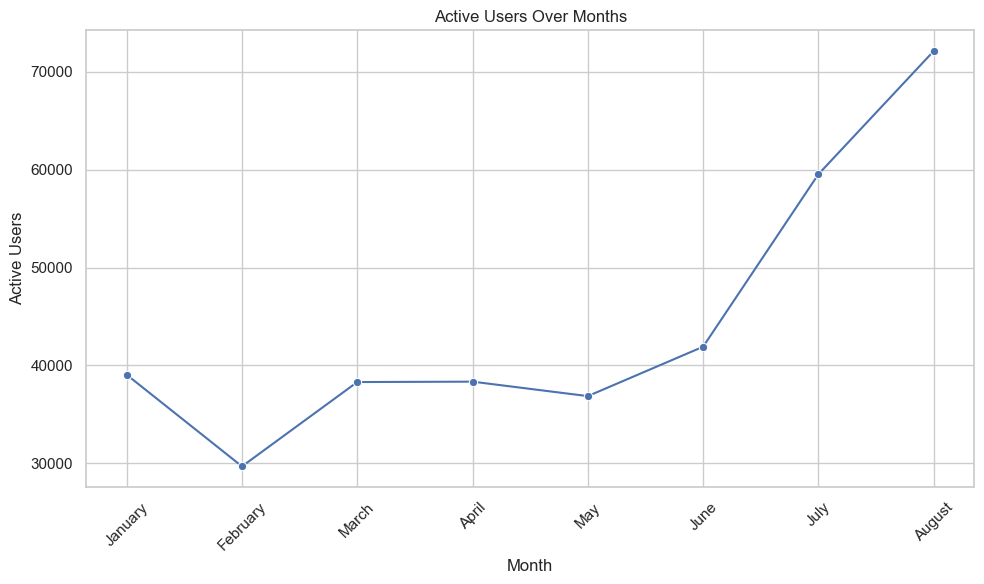

In [145]:
# Plot activeUsers over months with seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y="activeUsers", marker="o")
plt.title("Active Users Over Months")
plt.xlabel("Month")
plt.ylabel("Active Users")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analysis of events (why has the number increased?)

In [17]:
events = preprocess_import_data(client.run_query(
    property_id=property_id,
    start_date = '2025-04-15',
    end_date='2025-09-25',
    dimensions=['eventName', 'date'],
    metrics=['activeUsers', 'engagedSessions', 'screenPageViews'],
))

events

,eventName,date,activeUsers,engagedSessions,screenPageViews
0,page_view,2025-08-04,3185,2040,4851
1,session_start,2025-08-04,3182,2037,0
2,page_view,2025-07-29,3162,1632,4349
3,session_start,2025-07-29,3160,1634,0
4,page_view,2025-09-03,2973,2063,4195
...,...,...,...,...,...
814,new_core_reader,2025-05-03,3,0,0
815,new_core_reader,2025-05-30,3,0,0
816,new_core_reader,2025-06-08,3,0,0
817,new_core_reader,2025-06-29,3,0,0


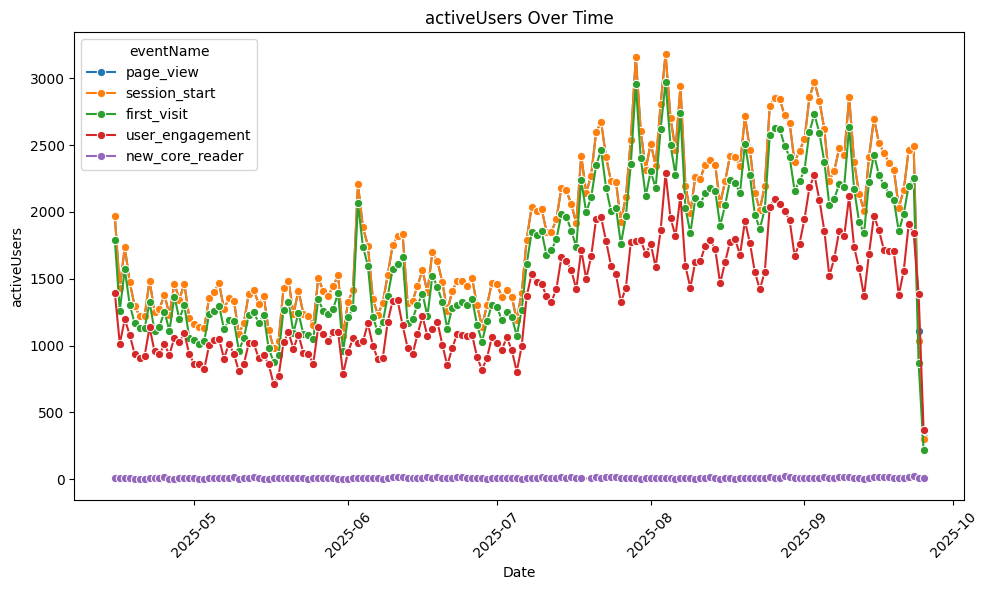

In [28]:
# Do a multiple line plot with seaborn for the events data (activeUsers), creating a function taking metric as

def plot_metric_by_event(events, metric):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=events, x='date', y=metric, hue='eventName', marker="o", estimator=np.sum)
    plt.title(f"{metric} Over Time")
    plt.xlabel("Date")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_metric_by_event(events, 'activeUsers')

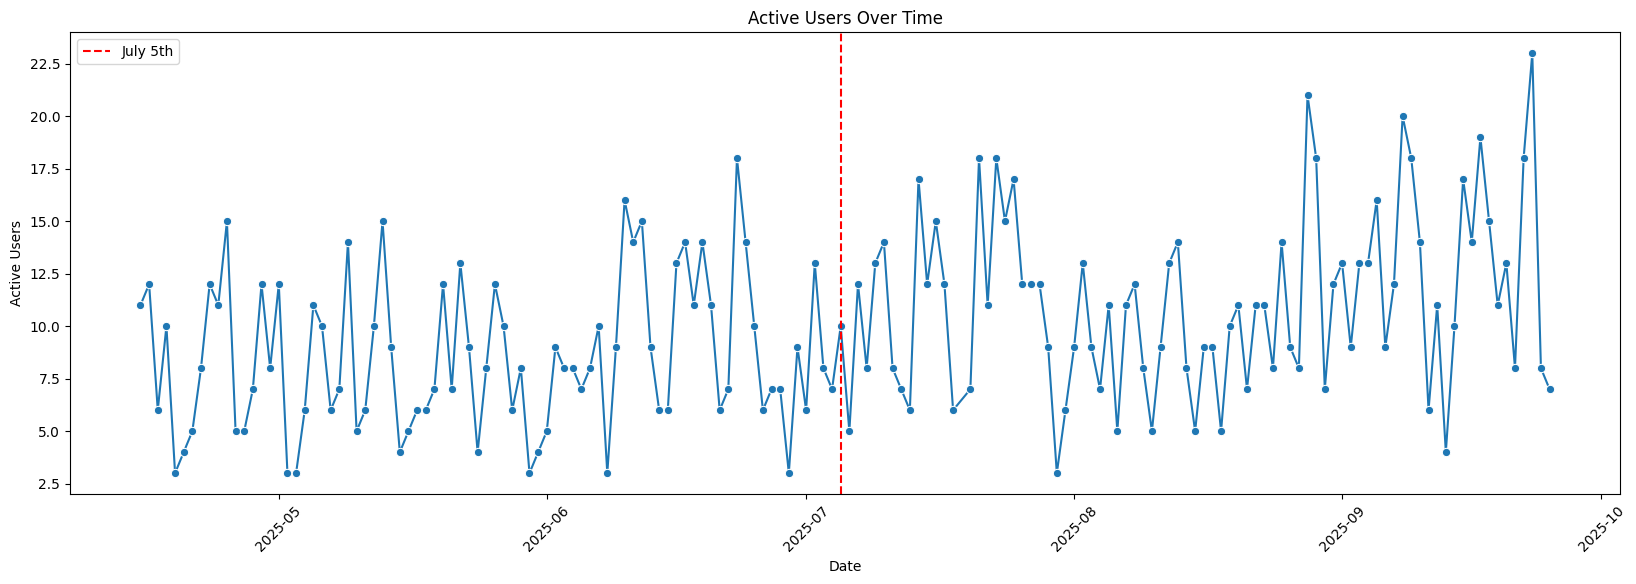

In [ ]:
# Plot the number of core readers, plus do a vertical line on July 5th
# Change the aspect ratio to landscape
plt.figure(figsize=(20, 6))
core_readers_events = events[events['eventName'] == 'new_core_reader']
sns.lineplot(data=core_readers_events, x='date', y="activeUsers", marker="o")
plt.axvline(pd.to_datetime('2025-07-05'), color='red', linestyle='--', label='July 5th')
plt.title("Active Users Over Time")
plt.xlabel("Date")
plt.ylabel("Active Users")
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [149]:
# Date with highest number of core readers
core_readers_events.loc[core_readers_events['activeUsers'].idxmax()+1]

eventName              new_core_reader
date               2025-09-08 00:00:00
activeUsers                         20
engagedSessions                      0
screenPageViews                      0
Name: 617, dtype: object

In [150]:
# Has the average number of core readers increased after July 5th compared to before?
# Has the average number of core readers increased after July 5th compared to before?
core_readers_before = core_readers_events[core_readers_events['date'] < pd.to_datetime('2025-07-05')]
core_readers_after = core_readers_events[core_readers_events['date'] >= pd.to_datetime('2025-07-05')]
# Number of days before and after
days_before = (pd.to_datetime('2025-07-05') - core_readers_before['date'].min()).days
days_after = (core_readers_after['date'].max() - pd.to_datetime('2025-07-05')).days
avg_core_readers_before = core_readers_before['activeUsers'].sum() / days_before
avg_core_readers_after = core_readers_after['activeUsers'].sum() / days_after

avg_core_readers_before, avg_core_readers_after


(np.float64(8.54320987654321), np.float64(10.819444444444445))

## Analisi dei tassi di ingaggio

In [176]:
engagement_metrics = preprocess_import_data(client.run_query(
    property_id=property_id,
    start_date='2024-01-01',
    end_date='2025-09-13',
    dimensions=['date'],
    metrics=['engagedSessions', 'bounceRate', 'activeUsers', 'averageSessionDuration']
))

engagement_metrics

,date,engagedSessions,bounceRate,activeUsers,averageSessionDuration
0,2025-09-03,2065,0.376321,2980,136.323860
1,2025-08-04,2041,0.426846,3193,120.753908
2,2025-08-07,1943,0.409602,2945,109.904160
3,2025-09-02,1928,0.390259,2863,118.648984
4,2025-08-27,1881,0.441010,2852,114.985394
...,...,...,...,...,...
617,2024-04-13,412,0.515864,686,146.838726
618,2024-08-10,409,0.513674,699,100.806591
619,2024-04-07,404,0.517324,670,171.966277
620,2024-08-11,402,0.528169,710,102.137610


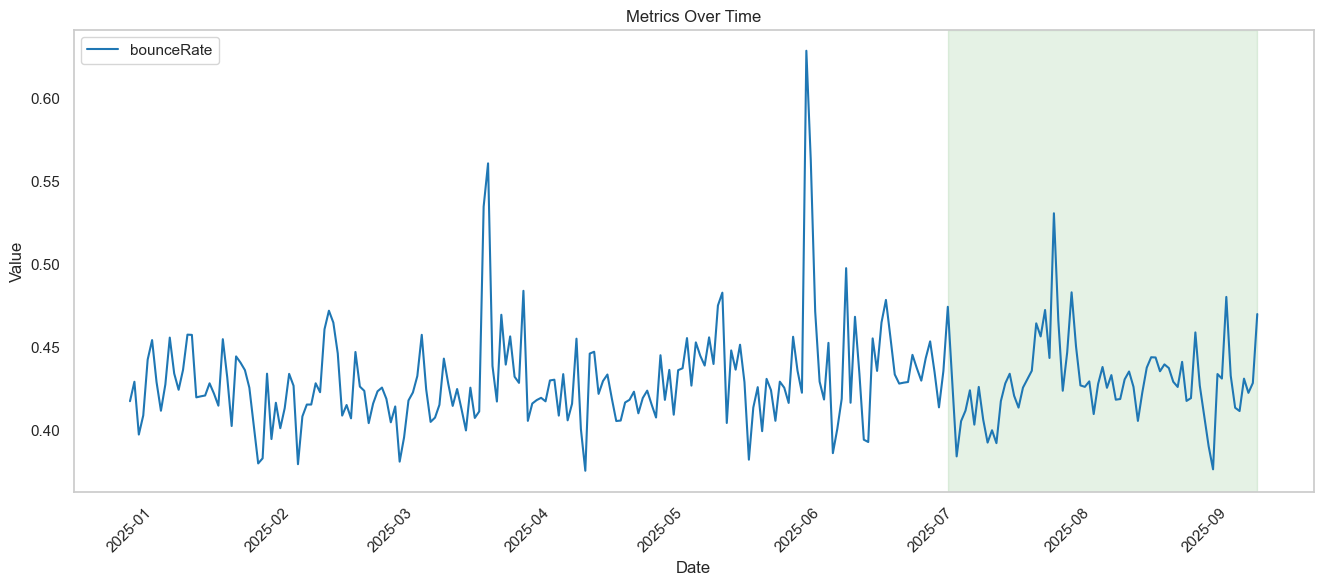

In [ ]:
def plot_multiple_metrics_by_date(data, metrics):
    # Use secondary y axis for the second metric
    plt.figure(figsize=(16, 6))
    # Use different colors for each metric
    colors = sns.color_palette("tab10", len(metrics))
    for i, metric in enumerate(metrics):
        if i == 0:
            sns.lineplot(data=data, x='date', y=metric, label=metric, color=colors[i])
        else:
            sns.lineplot(data=data, x='date', y=metric, label=metric, ax=plt.gca().twinx(), color=colors[i])
    plt.axvspan(pd.to_datetime('2025-07-05'), pd.to_datetime('2025-09-13'), color='green', alpha=0.1)
     # Add legend for the vertical span
    plt.title('Metrics Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()



plot_multiple_metrics_by_date(engagement_metrics, ['bounceRate'])

In [ ]:
# Sort by bounce rate descending
engagement_metrics.sort_values(by='bounceRate', ascending=False)


,date,engagedSessions,bounceRate,activeUsers
159,2025-06-03,904,0.628289,2210
142,2025-06-04,925,0.562441,1888
83,2025-03-23,1075,0.560507,2132
123,2025-03-22,960,0.534433,1807
23,2025-07-29,1634,0.530460,3169
...,...,...,...,...
132,2025-03-03,936,0.380952,1297
225,2025-01-30,764,0.379870,1043
203,2025-02-08,826,0.379414,1153
0,2025-09-03,2065,0.376321,2980


## Analisi durata media sessioni

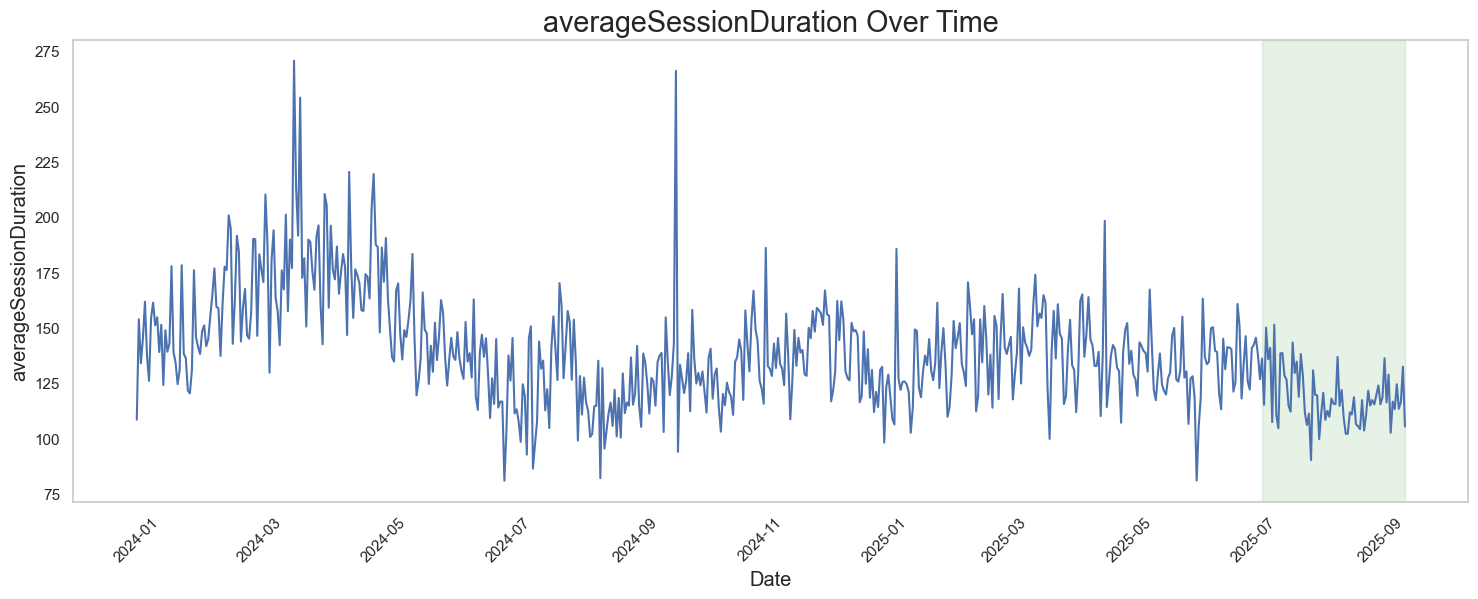

In [177]:
plot_metric_by_date(engagement_metrics, metric='averageSessionDuration')


In [187]:
average_session_duration_dict = {}

average_session_duration_dict['from_july_6'] = engagement_metrics[engagement_metrics['date'] > pd.to_datetime('2025-07-05')]['averageSessionDuration'].mean()
average_session_duration_dict['before_july_6'] = engagement_metrics[
    (engagement_metrics['date'] >= pd.to_datetime('2025-01-01')) &
    (engagement_metrics['date'] <= pd.to_datetime('2025-07-05'))
]['averageSessionDuration'].mean()

average_session_duration_dict['from_july_6'] / average_session_duration_dict['before_july_6'] - 1 

np.float64(-0.1278798304697022)

## Analisi per canali

In [29]:
channels = preprocess_import_data(
    client.run_query(
        property_id=property_id,
        start_date="2023-01-01",
        end_date="2025-09-24",
        dimensions=["date", "sessionSourceMedium", "sessionDefaultChannelGroup"],
        metrics=[
            "screenPageViews",
            "sessions",
            "engagedSessions",
            "bounceRate",
            "activeUsers",
            "averageSessionDuration",
        ],
    )
)

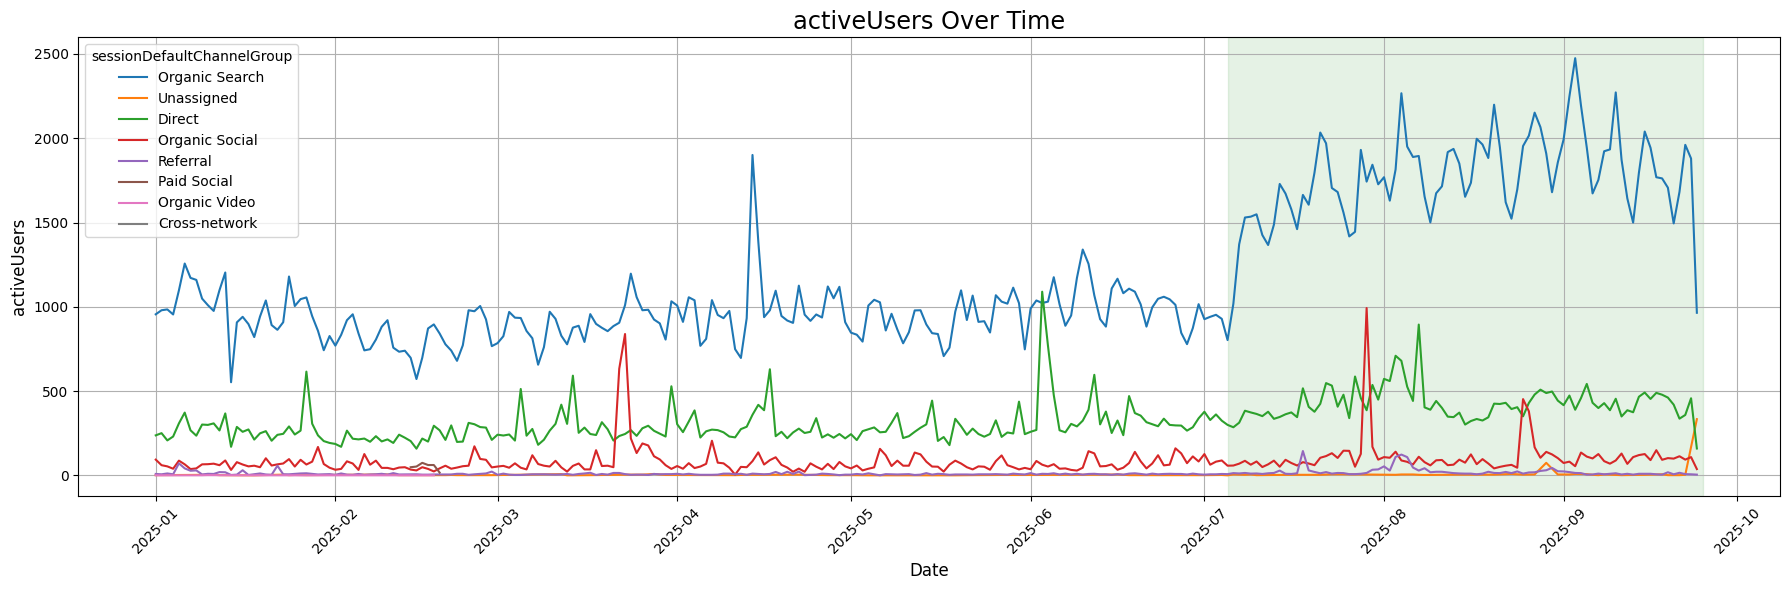

In [38]:
def plot_metric_by_date_with_hue(data, metric, hue, date_filter=None):
    # Apply date filter if provided
    if date_filter is not None:
        start_date, end_date = date_filter
        data = data[
            (data["date"] >= pd.to_datetime(start_date))
            & (data["date"] <= pd.to_datetime(end_date))
        ]
    plt.figure(figsize=(18, 6))
    plt.axvspan(pd.to_datetime('2025-07-05'), pd.to_datetime('2025-09-25'), color='green', alpha=0.1)
    # Compute the sum as the estimator
    sns.lineplot(data=data, x="date", y=metric, hue=hue, errorbar=None, estimator=np.sum)
    plt.title(f"{metric} Over Time", fontsize="xx-large")
    plt.xlabel("Date", fontsize="large")
    plt.ylabel(metric, fontsize="large")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()


plot_metric_by_date_with_hue(
    channels, metric="activeUsers", hue="sessionDefaultChannelGroup",
    date_filter=('2025-01-01', '2025-09-24')
)

In [37]:
channels.groupby('date')['activeUsers'].sum().tail(20)

date
2025-09-05    2613
2025-09-06    2215
2025-09-07    2293
2025-09-08    2450
2025-09-09    2401
2025-09-10    2829
2025-09-11    2361
2025-09-12    2109
2025-09-13    1992
2025-09-14    2394
2025-09-15    2673
2025-09-16    2499
2025-09-17    2416
2025-09-18    2346
2025-09-19    2293
2025-09-20    2022
2025-09-21    2151
2025-09-22    2426
2025-09-23    2454
2025-09-24    1505
Name: activeUsers, dtype: int64

In [ ]:
# Sort channels by overall active users
channels.groupby('sessionDefaultChannelGroup')['activeUsers'].sum().sort_values(ascending=False)

sessionDefaultChannelGroup
Organic Search    752872
Direct            237528
Organic Social     75423
Referral           10237
Paid Search         2735
Unassigned          1047
Paid Social          318
Organic Video         74
Email                 10
Cross-network          3
Name: activeUsers, dtype: int64

In [35]:
# Extract the dates for the highest peaks in organic social traffic
channels[channels['sessionDefaultChannelGroup'] == 'Organic Social'].sort_values(by='activeUsers', ascending=False).head(10)

,date,sessionSourceMedium,sessionDefaultChannelGroup,screenPageViews,sessions,engagedSessions,bounceRate,activeUsers,averageSessionDuration
329,2025-07-29,lm.facebook.com / referral,Organic Social,656,629,110,0.825119,617,29.793196
414,2025-03-23,lm.facebook.com / referral,Organic Social,497,483,55,0.886128,457,19.211371
478,2025-03-22,lm.facebook.com / referral,Organic Social,409,389,49,0.874036,381,23.307876
502,2025-08-25,t.co / referral,Organic Social,352,326,218,0.331288,320,146.648925
516,2025-03-23,m.facebook.com / referral,Organic Social,259,255,13,0.949020,253,5.247425
517,2025-07-29,m.facebook.com / referral,Organic Social,251,241,13,0.946058,239,4.978921
519,2025-08-26,t.co / referral,Organic Social,241,225,137,0.391111,217,155.295794
522,2025-03-22,m.facebook.com / referral,Organic Social,149,146,11,0.924658,146,5.844863
537,2025-08-16,facebook.com / referral,Organic Social,97,96,63,0.343750,96,24.085241
541,2025-03-24,lm.facebook.com / referral,Organic Social,95,93,12,0.870968,89,23.544856


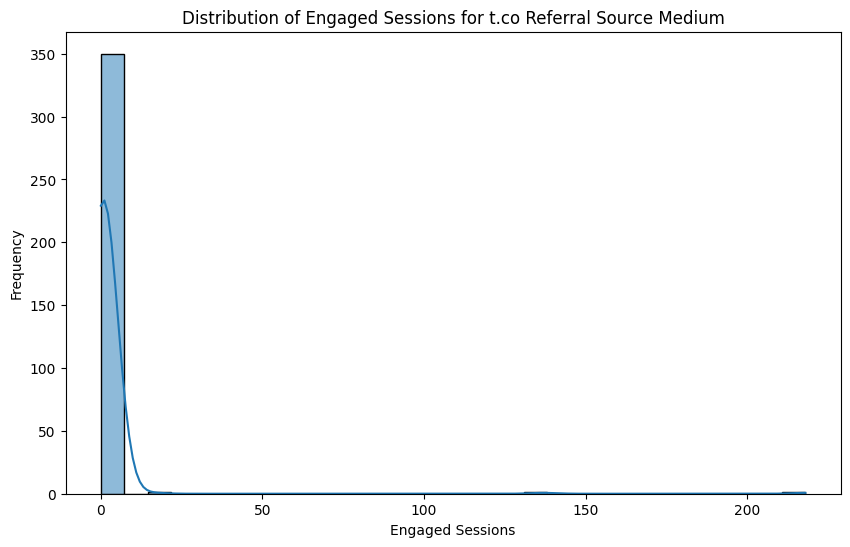

In [42]:
# Group by sessionSourceMedium and compute bounce rate using engagedSessions and sessions
channels_grouped = channels.groupby('sessionSourceMedium').agg({
    'engagedSessions': 'sum',
    'sessions': 'sum'
}).reset_index()
channels_grouped['computedBounceRate'] = 1 - (channels_grouped['engagedSessions'] / channels_grouped['sessions'])
channels_grouped = channels_grouped.sort_values(by='computedBounceRate')
channels_grouped.sort_values(by='sessions', ascending=False).head(10)

# Take only referral source medium
referral_channels = channels[channels['sessionSourceMedium'].str.contains('referral', case=False, na=False)]
# Plot histogram of engagedSessions for t.co referral source medium
plt.figure(figsize=(10, 6))
sns.histplot(referral_channels[referral_channels['sessionSourceMedium'].str.contains('t.co', case=False, na=False)], x='engagedSessions', bins=30, kde=True)
plt.title('Distribution of Engaged Sessions for t.co Referral Source Medium')
plt.xlabel('Engaged Sessions')
plt.ylabel('Frequency')
plt.show()


In [ ]:
avg_active_users = (
    channels.groupby("sessionDefaultChannelGroup")["activeUsers"]
    .mean()
    .reset_index()
    .sort_values(by="activeUsers", ascending=False)
)

avg_active_users

,sessionDefaultChannelGroup,activeUsers
0,Direct,327.003906
2,Organic Search,153.104622
6,Paid Social,25.076923
3,Organic Social,13.210436
8,Unassigned,2.212719
7,Referral,1.919008
1,Email,1.500000
4,Organic Video,0.980769
5,Paid Search,0.928571


In [290]:
# Get active users of direct default channel group ordered by date
direct_channel_data = channels[channels["sessionDefaultChannelGroup"] == "Direct"]
direct_channel_data = direct_channel_data.groupby("date")["activeUsers"].sum().reset_index()

pd.set_option('display.max_rows', None)
direct_channel_data

,date,activeUsers
0,2025-01-01,238
1,2025-01-02,251
2,2025-01-03,208
3,2025-01-04,231
4,2025-01-05,309
5,2025-01-06,373
6,2025-01-07,268
7,2025-01-08,236
8,2025-01-09,302
9,2025-01-10,300


## Analisi per dispositivi elettronici

## Focus Cult Movies

In [8]:
page_paths = preprocess_import_data(
    client.run_query(
        property_id=property_id,
        start_date="2025-01-01",
        end_date="2025-09-13",
        dimensions=["date", "pagePath"],
        metrics=[
            "screenPageViews",
            "engagedSessions",
            "bounceRate",
            "activeUsers",
            "averageSessionDuration",
        ],
    )
)

In [20]:
page_paths['pagePath'][1]

'/461334/festival-di-cinema/biennale-del-cinema-di-venezia/nino-18-giorni-a-venezia-il-documentario-su-nino-dangelo-diretto-dal-figlio-toni.html'

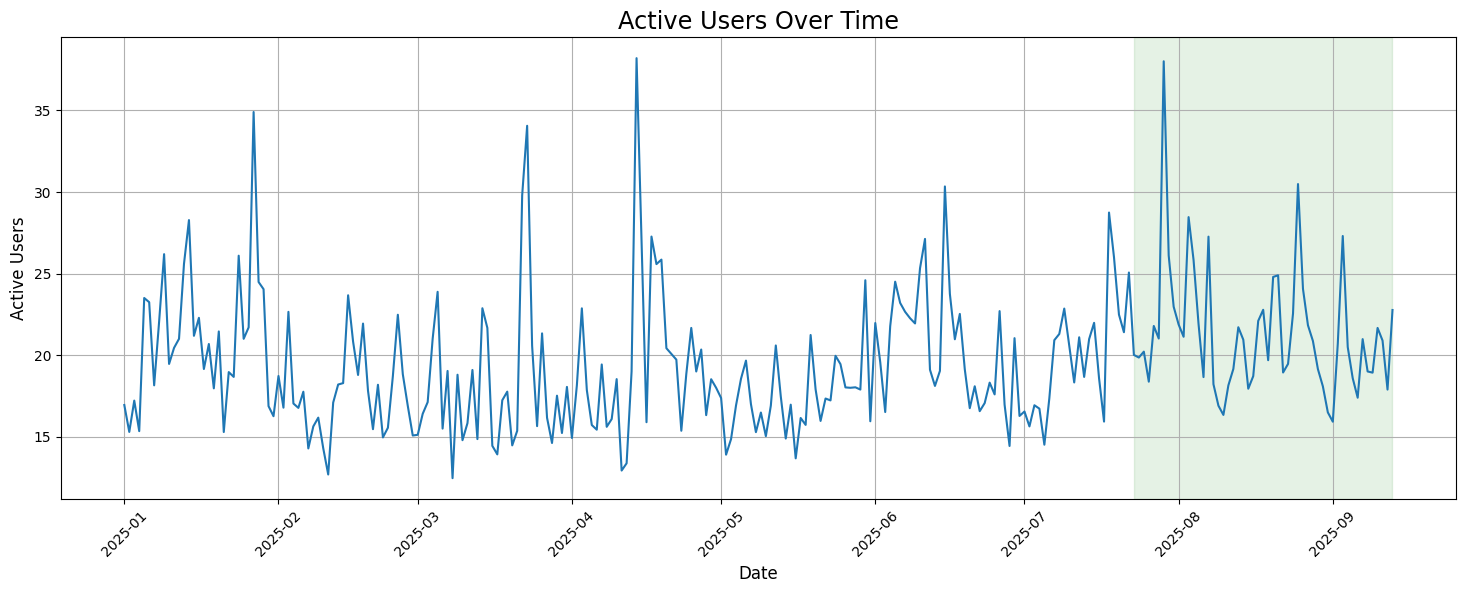

In [28]:
def is_cult_movies(path):
    '''Match path with "cult-movie" substring'''
    path_lower = path.lower()
    return "cult-movie" in path_lower

page_paths['is_cult_movie'] = page_paths['pagePath'].apply(is_cult_movies)
# Take the first date for which is_cult_movie is True
first_cult_movie_date = page_paths[page_paths['is_cult_movie']]['date'].min()

# Plot views over time, highlighting the period after the first cult movie page
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6))
sns.lineplot(data=page_paths, x='date', y='activeUsers', errorbar=None)
plt.axvspan(first_cult_movie_date, pd.to_datetime('2025-09-13'), color='green', alpha=0.1)
plt.title('Active Users Over Time', fontsize='xx-large')
plt.xlabel('Date', fontsize='large')
plt.ylabel('Active Users', fontsize='large')
plt.xticks(rotation=45)
plt.grid()
plt.show()



Timestamp('2025-01-01 00:00:00')